*Multi-task learning in Self eXplainable Deep Neural Networks*
==============================================================

***Master's thesis code***

*Part 1: Datasets Overview*

**Author:** *Adrian Domagała*

# Datasets Overview

In this section, I will conduct a preliminary analysis of the datasets listed below and prepare each for further research. All datasets have been sourced from online references specified in *Exploring Multi-Task Learning for Explainability* by Foivos Charalampakos and Iordanis Koutsopoulos. Utilized datasets:

-   Adult *(https://archive.ics.uci.edu/dataset/2/adult)* - The dataset was extracted by Barry Becker from the 1994 U.S. Census database. Based on 14 features it predicts whether individual annual income exceeds $50,000. 

-   Titanic *(https://www.openml.org/search?type=data&sort=runs&id=40945&status=active)* - The dataset contains of 14 features and describes the survival status of individual passengers on the Titanic. 

- Auto MPG *(https://archive.ics.uci.edu/dataset/9/auto+mpg)* - The dataset comprises 7 features and pertains to city-cycle fuel consumption given in miles per gallon (MPG).

- California Housing *(https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html)* - The dataset provides information on block groups in California based on the 1990 Census. It encompasses 8 features and median house value as predictive objective.

- Wine Quality *(https://archive.ics.uci.edu/dataset/186/wine+quality)* - The original dataset consists of two subsets related to the red and white variants of the Portuguese "Vinho Verde" wine. For this study, I will be using only the red wine dataset. This subset includes 12 features that have been used to assess the quality of the wines.

For every dataset, I will adhere to the following workflow:

- Data Acquisition 
- Handling Invalid and Empty Values
- Categorical and Continuous Data Exploration
- Preparation of Models' Input Data and Targets

## Preparations

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import os

import urllib.request
import tarfile
import io
import arff
import ssl
import dataclasses

### Defining plotting functions

In [2]:
def plot_df_numerical_features(df, title, y=2, kind='hist'):
    numerical_features = df.select_dtypes(include='number').columns
    rows_numerical = ((len(numerical_features)-1)//y)+1
    fig, axes = plt.subplots(nrows=rows_numerical, ncols=y, figsize=(8*y, 6*rows_numerical))
    for numerical_feature, ax in zip(numerical_features, axes.flatten()):
        bins = b if (b := df[numerical_feature].nunique()) < 150 else 150
        df[numerical_feature].plot(ax=ax, grid=True, title=f'Column: {numerical_feature}', kind=kind, bins=bins, ylabel='Occurrences', xlabel=numerical_feature)
    for i in range(len(axes.flatten())-len(numerical_features)):
        fig.delaxes(axes.flatten()[-1-i])
    fig.suptitle(title, fontsize=16, y=1)
    fig.tight_layout()
    plt.show()

In [3]:
def plot_df_categorical_features(df, title, y=2, kind='bar'):
    categorical_features = df.select_dtypes(include='object').columns
    rows_num = ((len(categorical_features)-1)//y)+1
    fig, axes = plt.subplots(nrows=rows_num, ncols=y, figsize=(8*y, 6*rows_num))
    for categorical_feature, ax in zip(categorical_features, axes.flatten()):
        df[categorical_feature].value_counts().plot(ax=ax, grid=True, title=f'Column: {categorical_feature}', kind=kind, ylabel='Occurrences', xlabel=categorical_feature)
    for i in range(len(axes.flatten())-len(categorical_features)):
        fig.delaxes(axes.flatten()[-1-i])
    fig.suptitle(title, fontsize=16, y=1)
    fig.tight_layout()
    plt.show()

### Defining Configurations

In [4]:
@dataclasses.dataclass
class Folders:
    datasets: str = "Datasets/"
    adult: str = "Adult/"
    auto: str = "Auto/"
    housing: str = "Housing/"
    titanic: str = "Titanic/"
    wine: str = "Wine/"
    study: str = "Studies"

    def __init__(self):
        for folder in dataclasses.astuple(self):
            os.makedirs(folder, exist_ok=True)

@dataclasses.dataclass
class Files:
    adult_data = Folders.datasets + "adult_data.pkl"
    adult_targets = Folders.datasets + "adult_targets.pkl"
    auto_data = Folders.datasets + "auto_data.pkl"
    auto_targets = Folders.datasets + "auto_targets.pkl"
    housing_data = Folders.datasets + "housing_data.pkl"
    housing_targets = Folders.datasets + "housing_targets.pkl"
    titanic_data = Folders.datasets + "titanic_data.pkl"
    titanic_targets = Folders.datasets + "titanic_targets.pkl"
    wine_data = Folders.datasets + "wine_data.pkl"
    wine_targets = Folders.datasets + "wine_targets.pkl"

@dataclasses.dataclass
class config:
    folders = Folders()
    files = Files()

## Adult

### Data Acquisition

In [5]:
adult = fetch_ucirepo(id=2)
adult_data = adult.data.original
print(adult_data.shape)
adult_data.head()

(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Handling Invalid and Empty Values

In [6]:
adult_df = adult_data.copy()
print(adult_df.isin(['?']).sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


In [7]:
adult_df[adult_df.isin(['?']).any(axis=1)].head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
14,40,Private,121772,Assoc-voc,11,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
38,31,Private,84154,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K
51,18,Private,226956,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,30,?,<=50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K


In [8]:
adult_df = adult_df[adult_df.ne('?').all(axis=1)]
print(adult_df.shape)
adult_df.isin(['?']).sum()

(46443, 15)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [9]:
print(adult_df.isnull().sum())

age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64


In [10]:
adult_df.dropna(how='any', inplace=True)

In [11]:
print(adult_df.shape)
adult_df.isnull().sum()

(45222, 15)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [12]:
adult_df.drop_duplicates(inplace=True)
print(adult_df.shape, '\n', adult_df.columns)

(45194, 15) 
 Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


### Categorical and Continuous Data Exploration

In [13]:
adult_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,45194.000000,4.519400e+04,45194.000000,45194.000000,45194.000000,45194.000000
mean,38.551755,1.897379e+05,10.119109,1102.112736,88.650308,40.941209
std,13.215806,1.056407e+05,2.552057,7508.705003,405.075515,12.006449
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173922e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783120e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379030e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


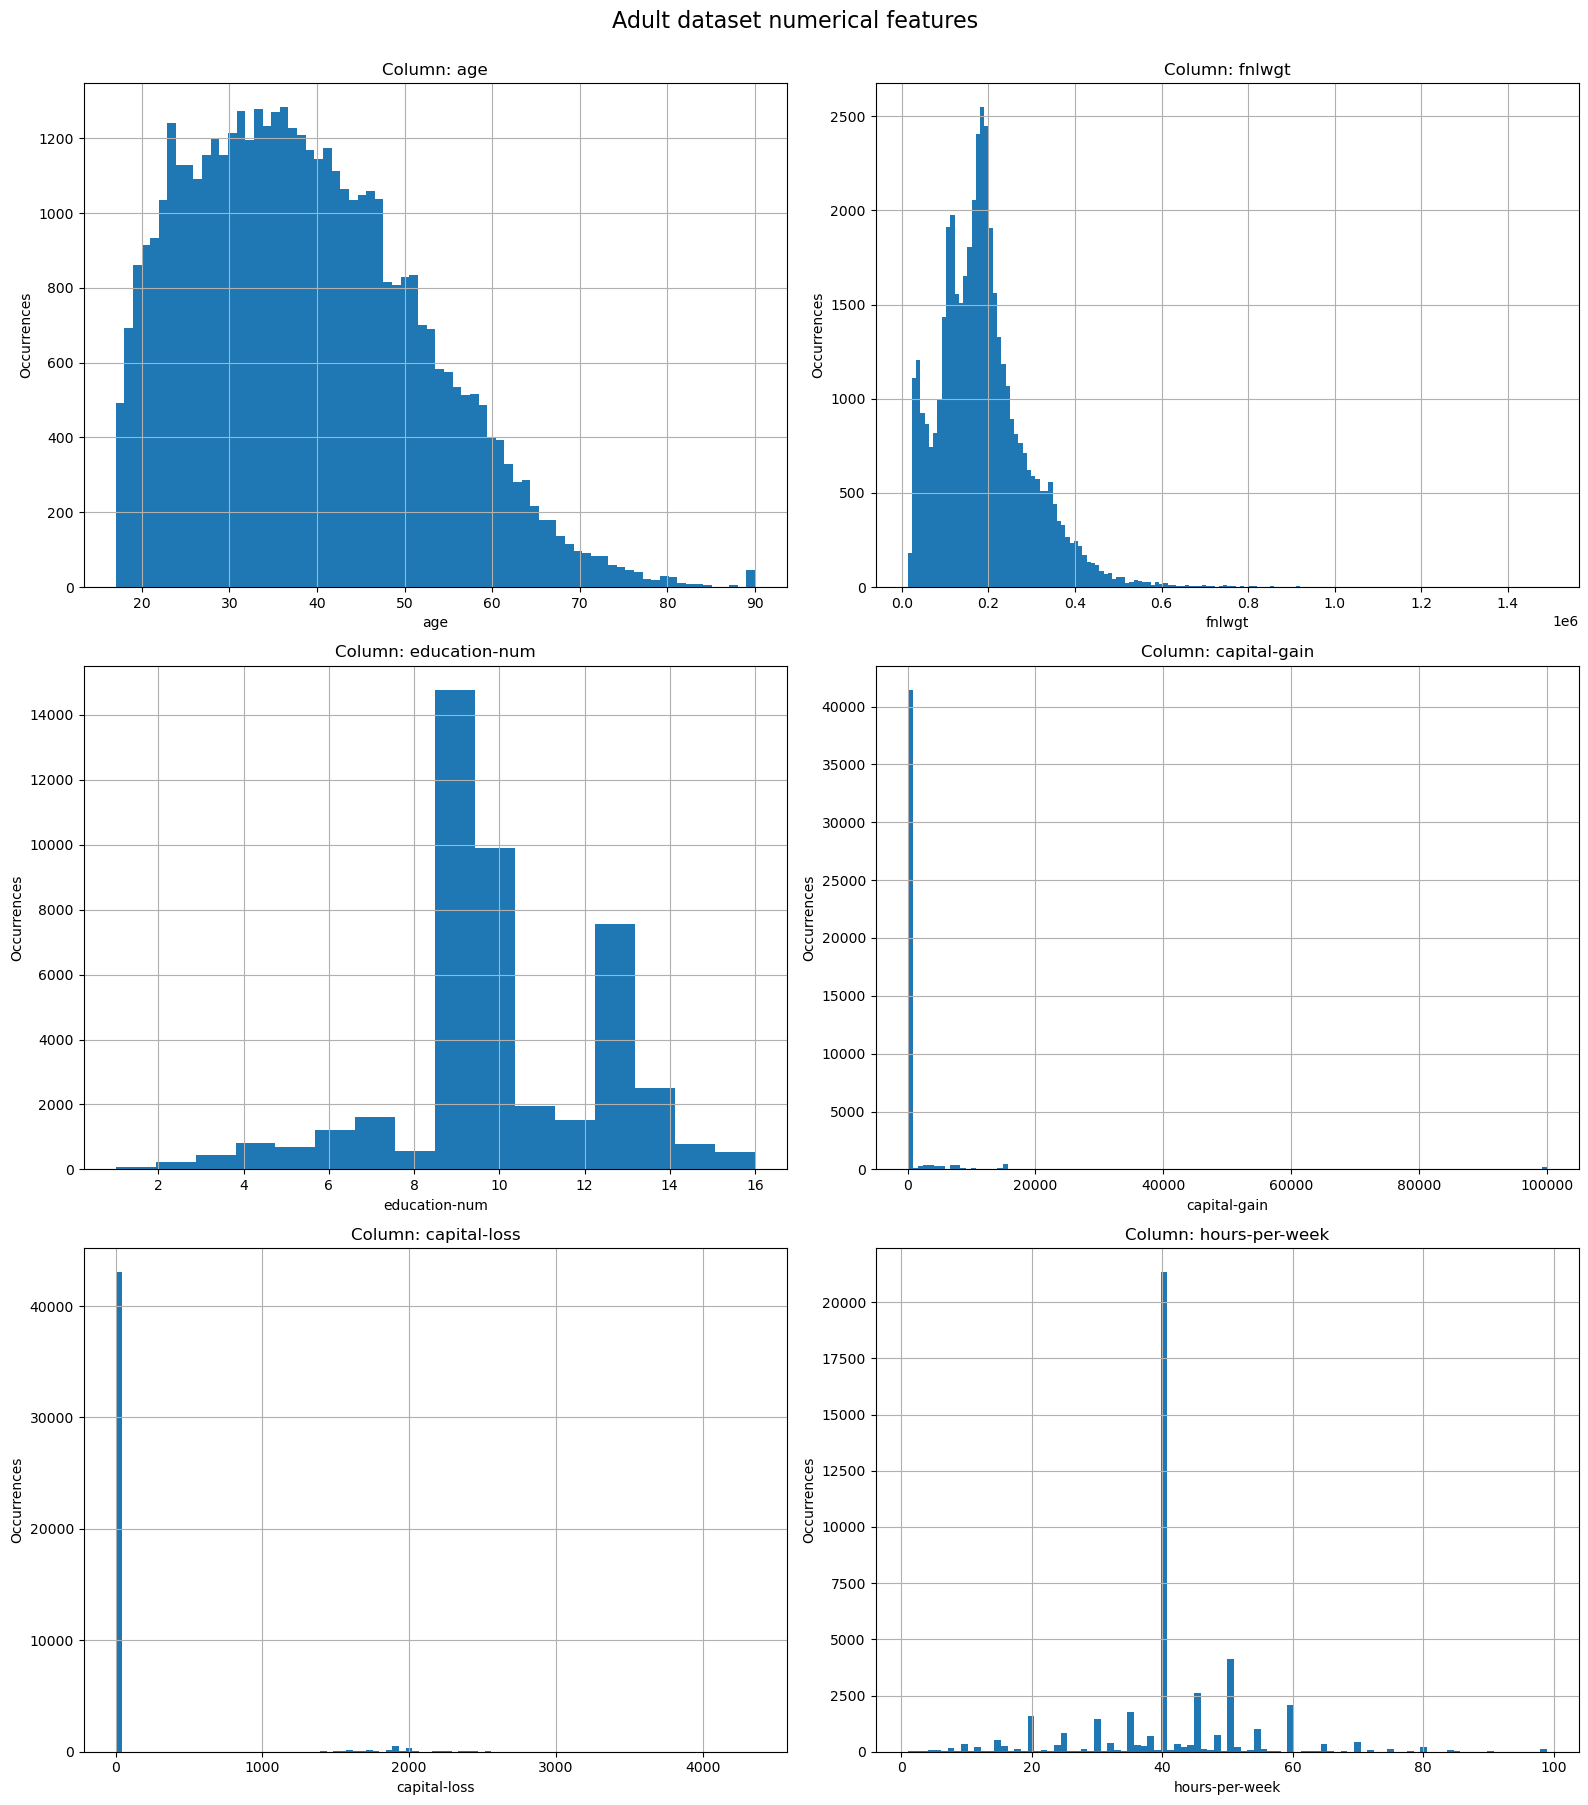

In [14]:
plot_df_numerical_features(adult_df, 'Adult dataset numerical features')

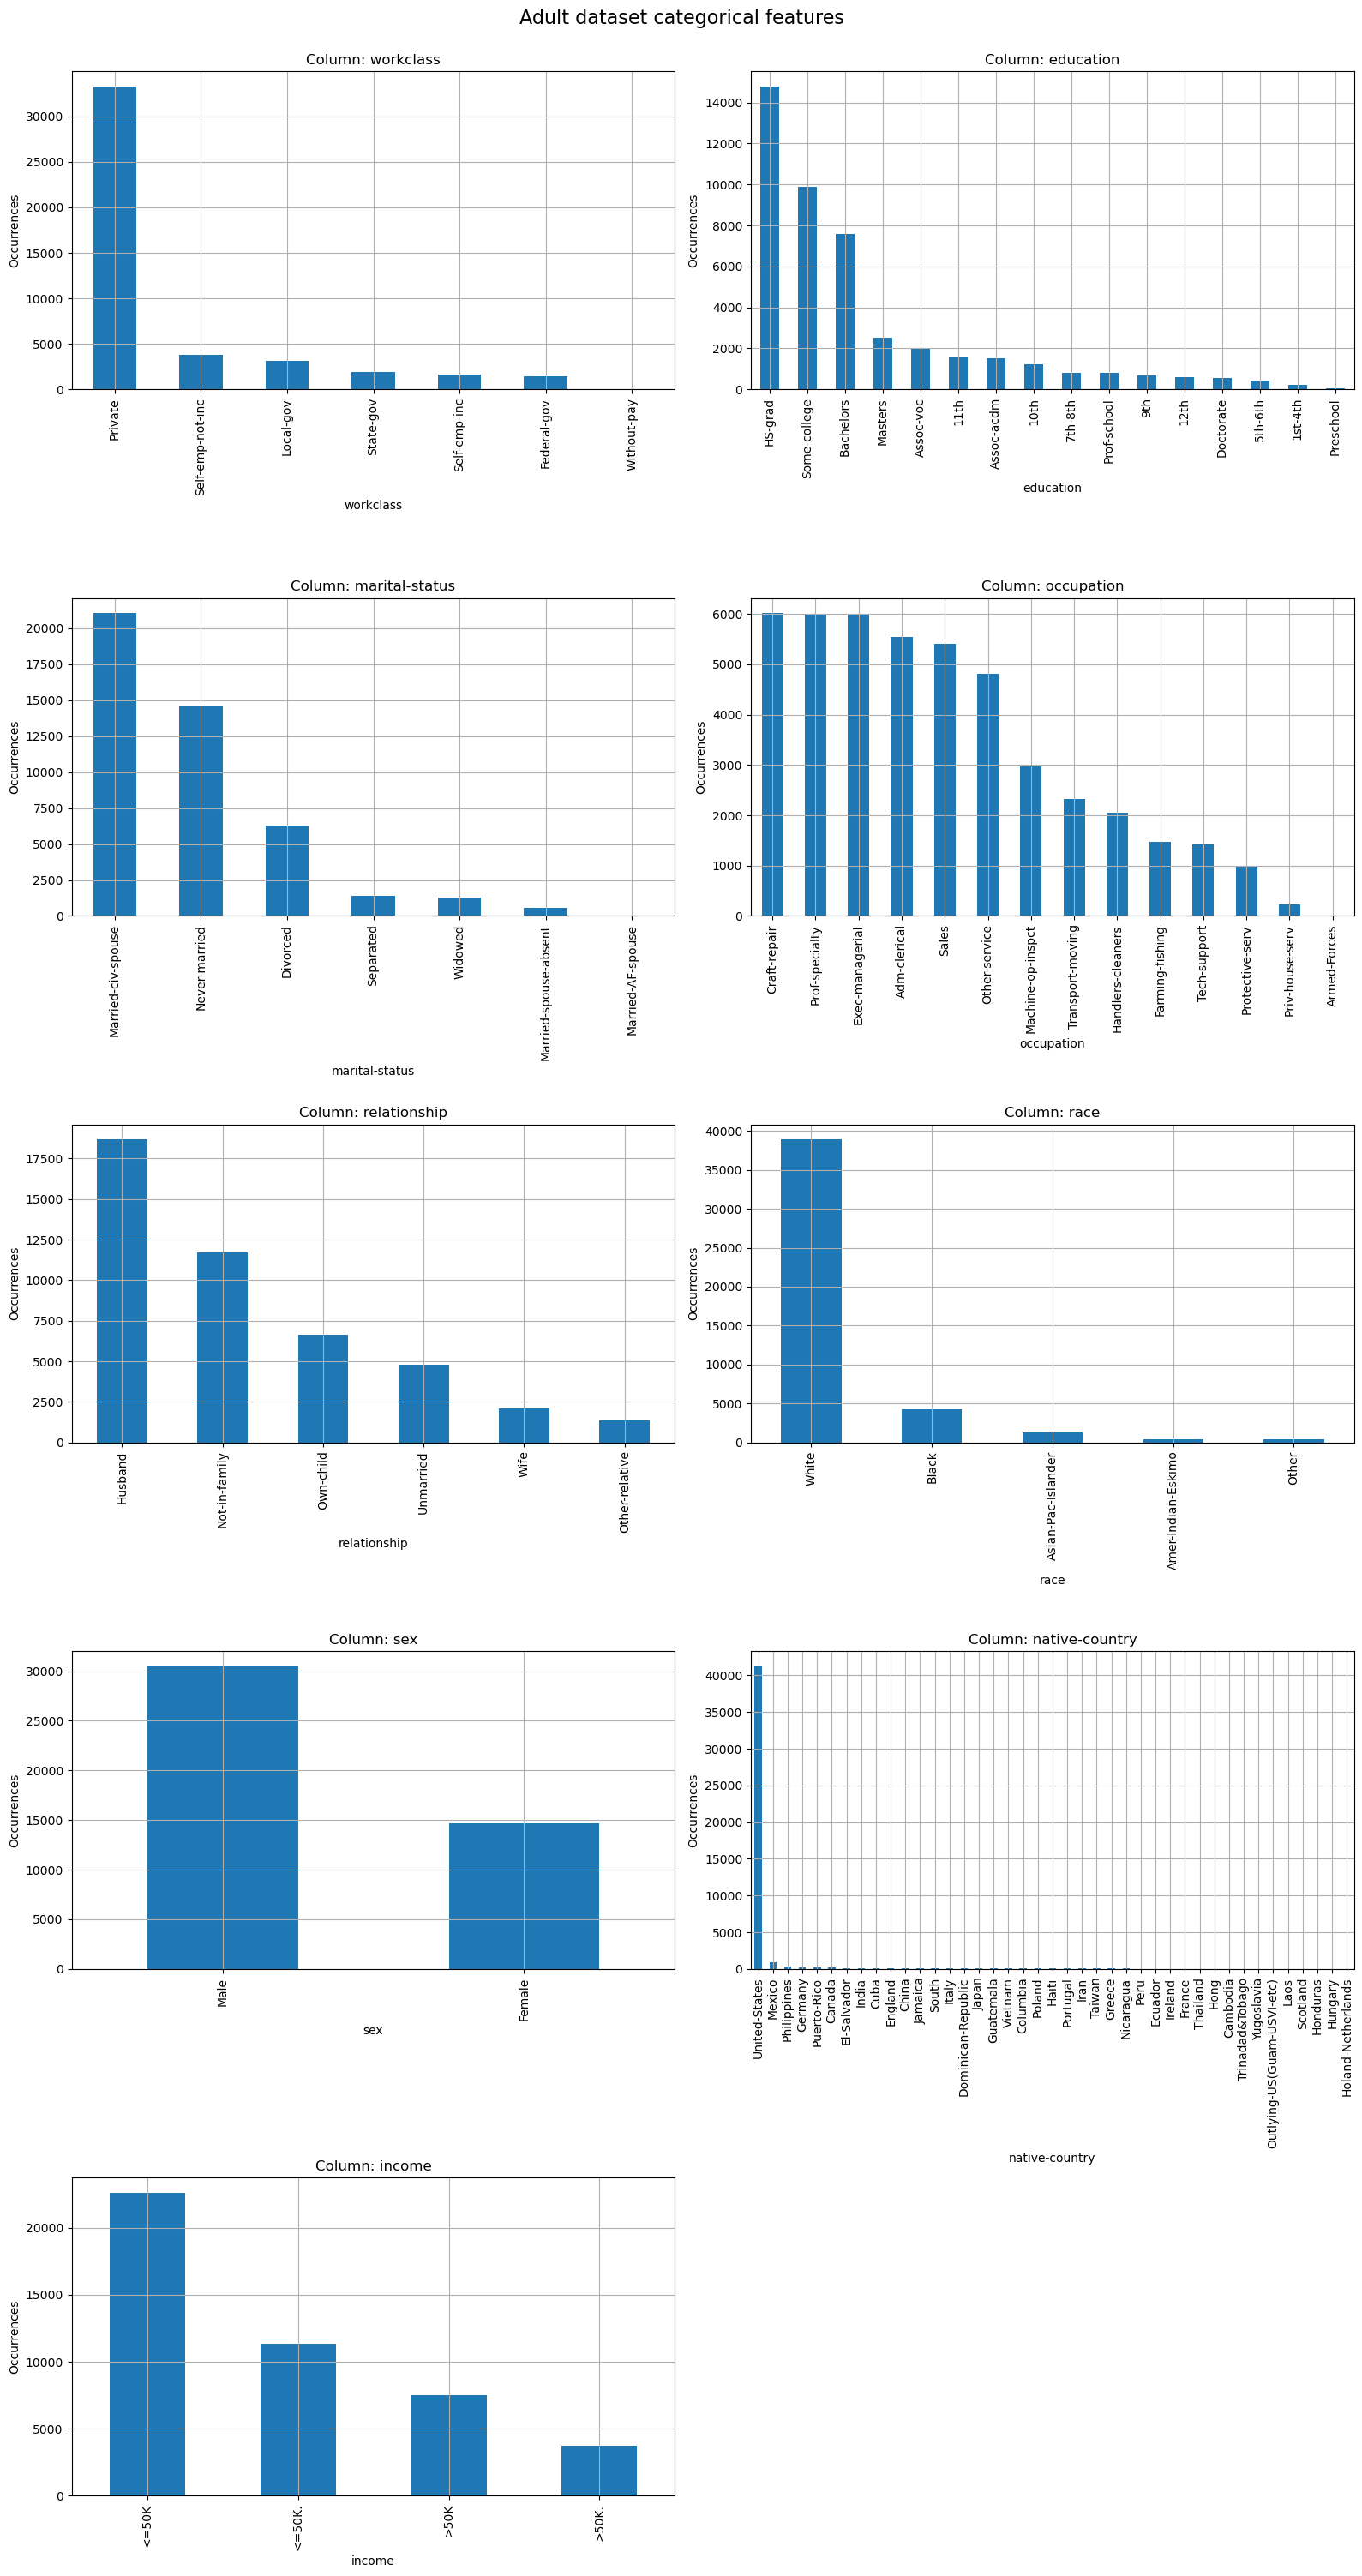

In [15]:
plot_df_categorical_features(adult_df, 'Adult dataset categorical features')

### Preparation of Models' Input Data and Targets

Due to repeated data in the "education-number" and "education" columns, the former was removed.

In [16]:
adult_X = adult_df.drop(['education-num', 'income'], axis=1)
adult_y = adult_df['income'].copy()

adult_y[(adult_y == '<=50K.') | (adult_y == '<=50K')] = 0
adult_y[(adult_y == '>50K.') | (adult_y == '>50K')] = 1
adult_y = adult_y.values.astype(float)

adult_X.to_pickle(config.files.adult_data)
pd.DataFrame(adult_y).to_pickle(config.files.adult_targets)

## Titanic

### Data Acquisition

In [17]:
url = "https://www.openml.org/data/download/16826755/phpMYEkMl"
context = ssl._create_unverified_context()
path = 'Datasets/Titanic.arff'
if not os.path.exists(path):
    with urllib.request.urlopen(url, context=context, timeout=30) as res:
        with open(path, 'xb') as f:
            f.write(res.read())

with open(path, 'r') as f:
    f = f.read()

raw_data = arff.load(f)
columns = [a[0] for a in raw_data['attributes']]
titanic_df = pd.DataFrame(raw_data['data'], columns=columns)
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


### Handling Invalid and Empty Values

In [18]:
print(titanic_df.shape)
titanic_df.nunique()

(1309, 14)


pclass          3
survived        2
name         1307
sex             2
age            98
sibsp           7
parch           8
ticket        929
fare          281
cabin         186
embarked        3
boat           27
body          121
home.dest     369
dtype: int64

In [19]:
titanic_df = titanic_df.drop(['name', 'ticket', 'home.dest'], axis=1)
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body
0,1.0,1,female,29.0000,0.0,0.0,211.3375,B5,S,2,NaN
1,1.0,1,male,0.9167,1.0,2.0,151.5500,C22 C26,S,11,NaN
2,1.0,0,female,2.0000,1.0,2.0,151.5500,C22 C26,S,None,NaN
3,1.0,0,male,30.0000,1.0,2.0,151.5500,C22 C26,S,None,135.0
4,1.0,0,female,25.0000,1.0,2.0,151.5500,C22 C26,S,None,NaN


In [20]:
titanic_df.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [21]:
titanic_df.isnull().sum()

pclass         0
survived       0
sex            0
age          263
sibsp          0
parch          0
fare           1
cabin       1014
embarked       2
boat         823
body        1188
dtype: int64

In [22]:
titanic_df = titanic_df.drop(['body', 'cabin', 'boat'], axis=1)
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1,female,29.0000,0.0,0.0,211.3375,S
1,1.0,1,male,0.9167,1.0,2.0,151.5500,S
2,1.0,0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,0,female,25.0000,1.0,2.0,151.5500,S


In [23]:
titanic_df.fillna({'age': titanic_df['age'].mean()}, inplace=True)
titanic_df.fillna({'fare': titanic_df['fare'].mean()}, inplace=True)
titanic_df.fillna({'embarked': titanic_df['embarked'].value_counts().idxmax()}, inplace=True)

titanic_df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

### Categorical and Continuous Data Exploration

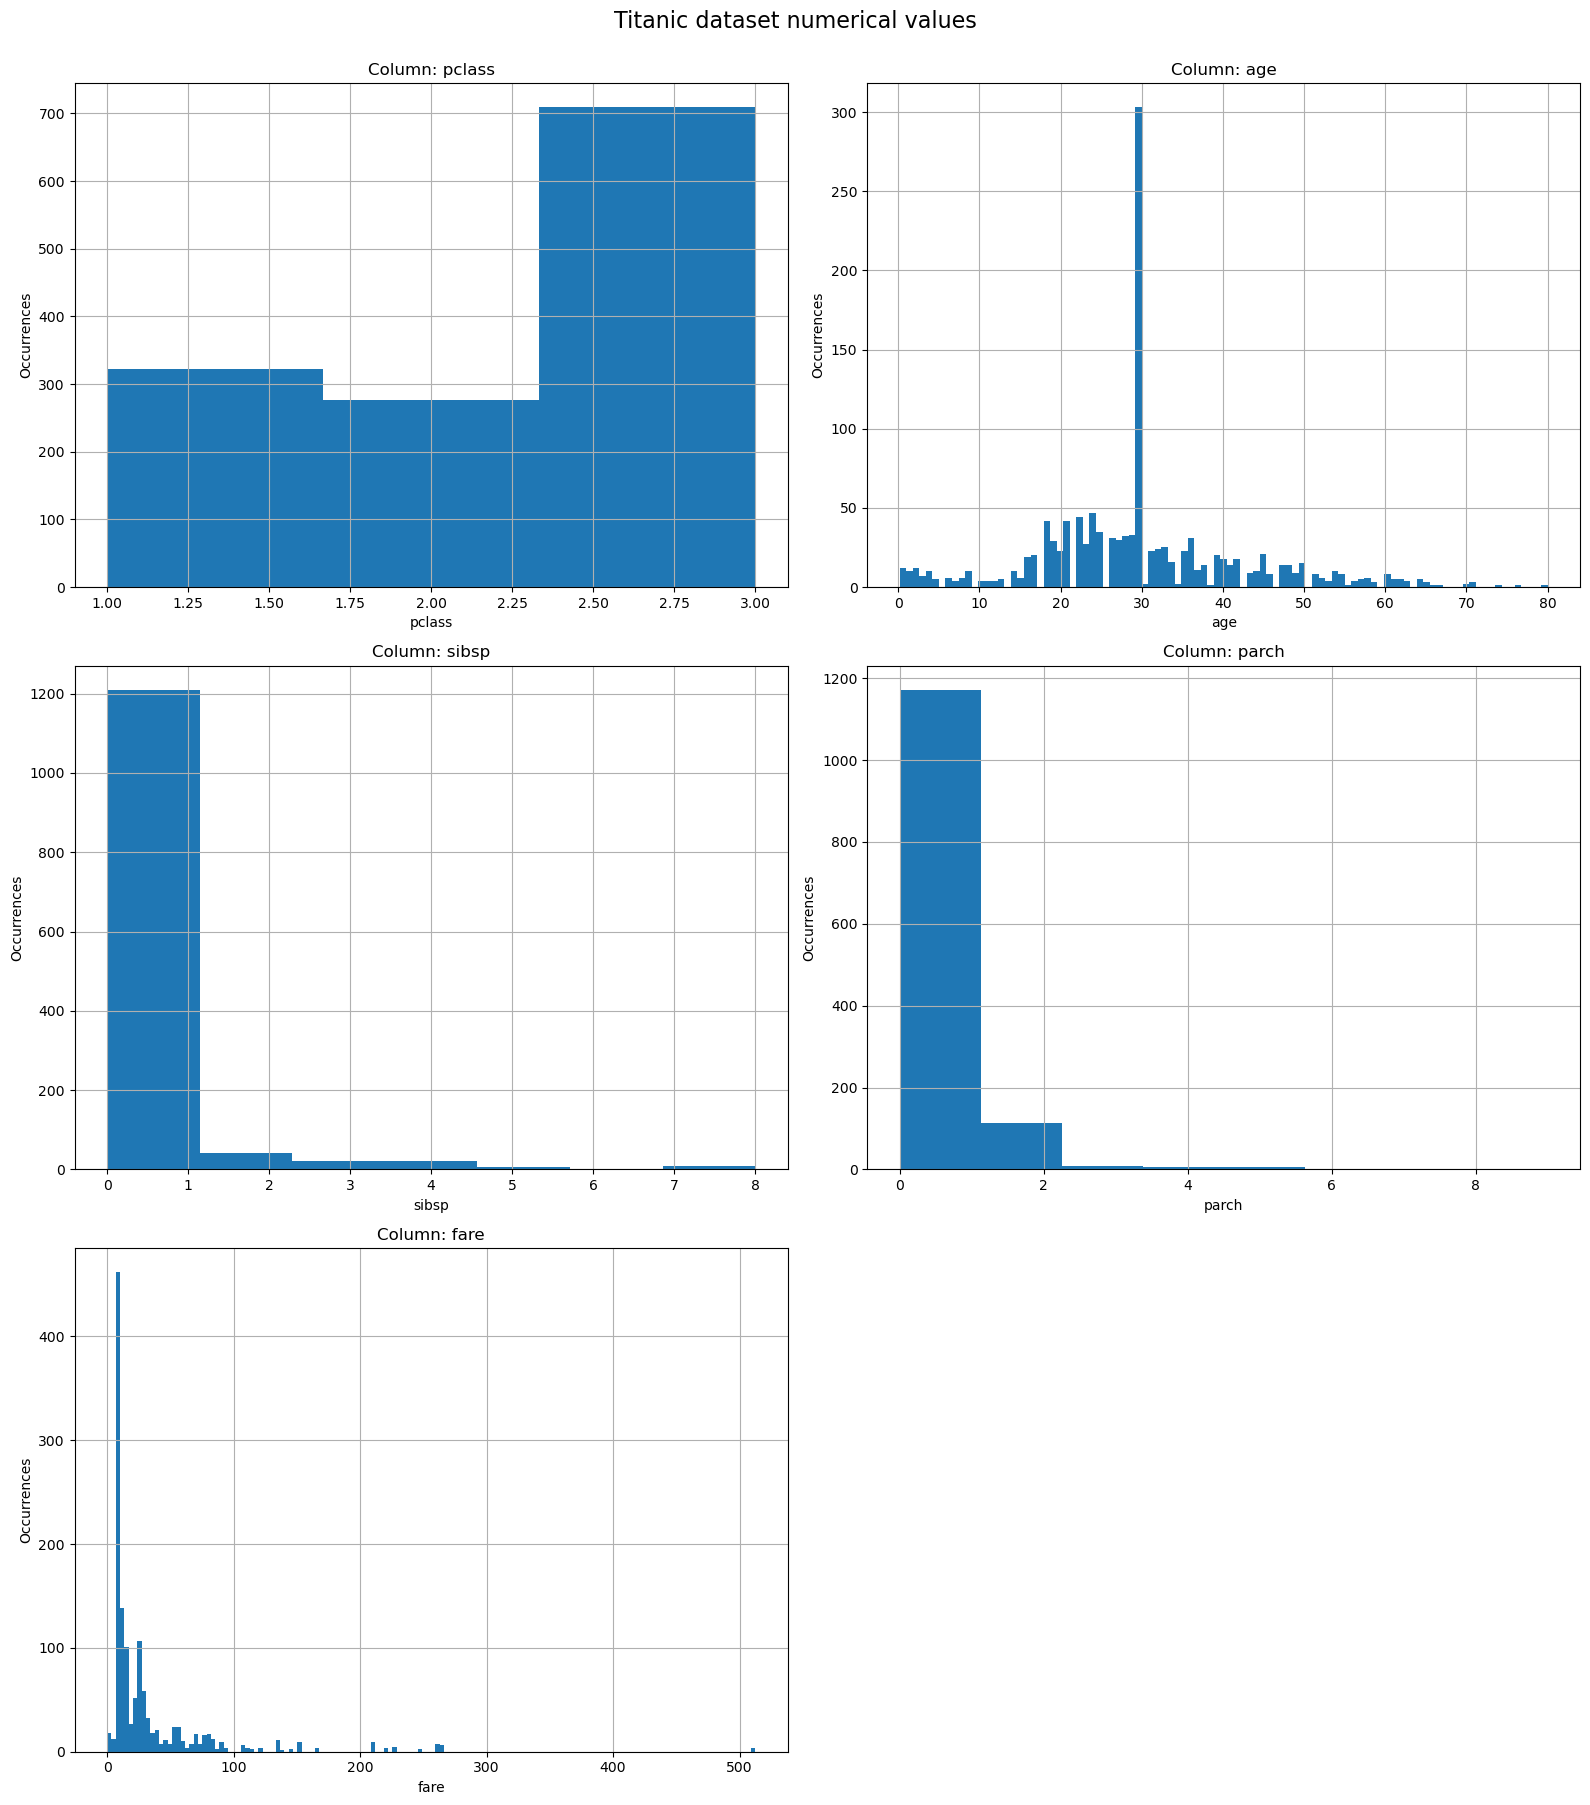

In [24]:
plot_df_numerical_features(titanic_df, 'Titanic dataset numerical values')

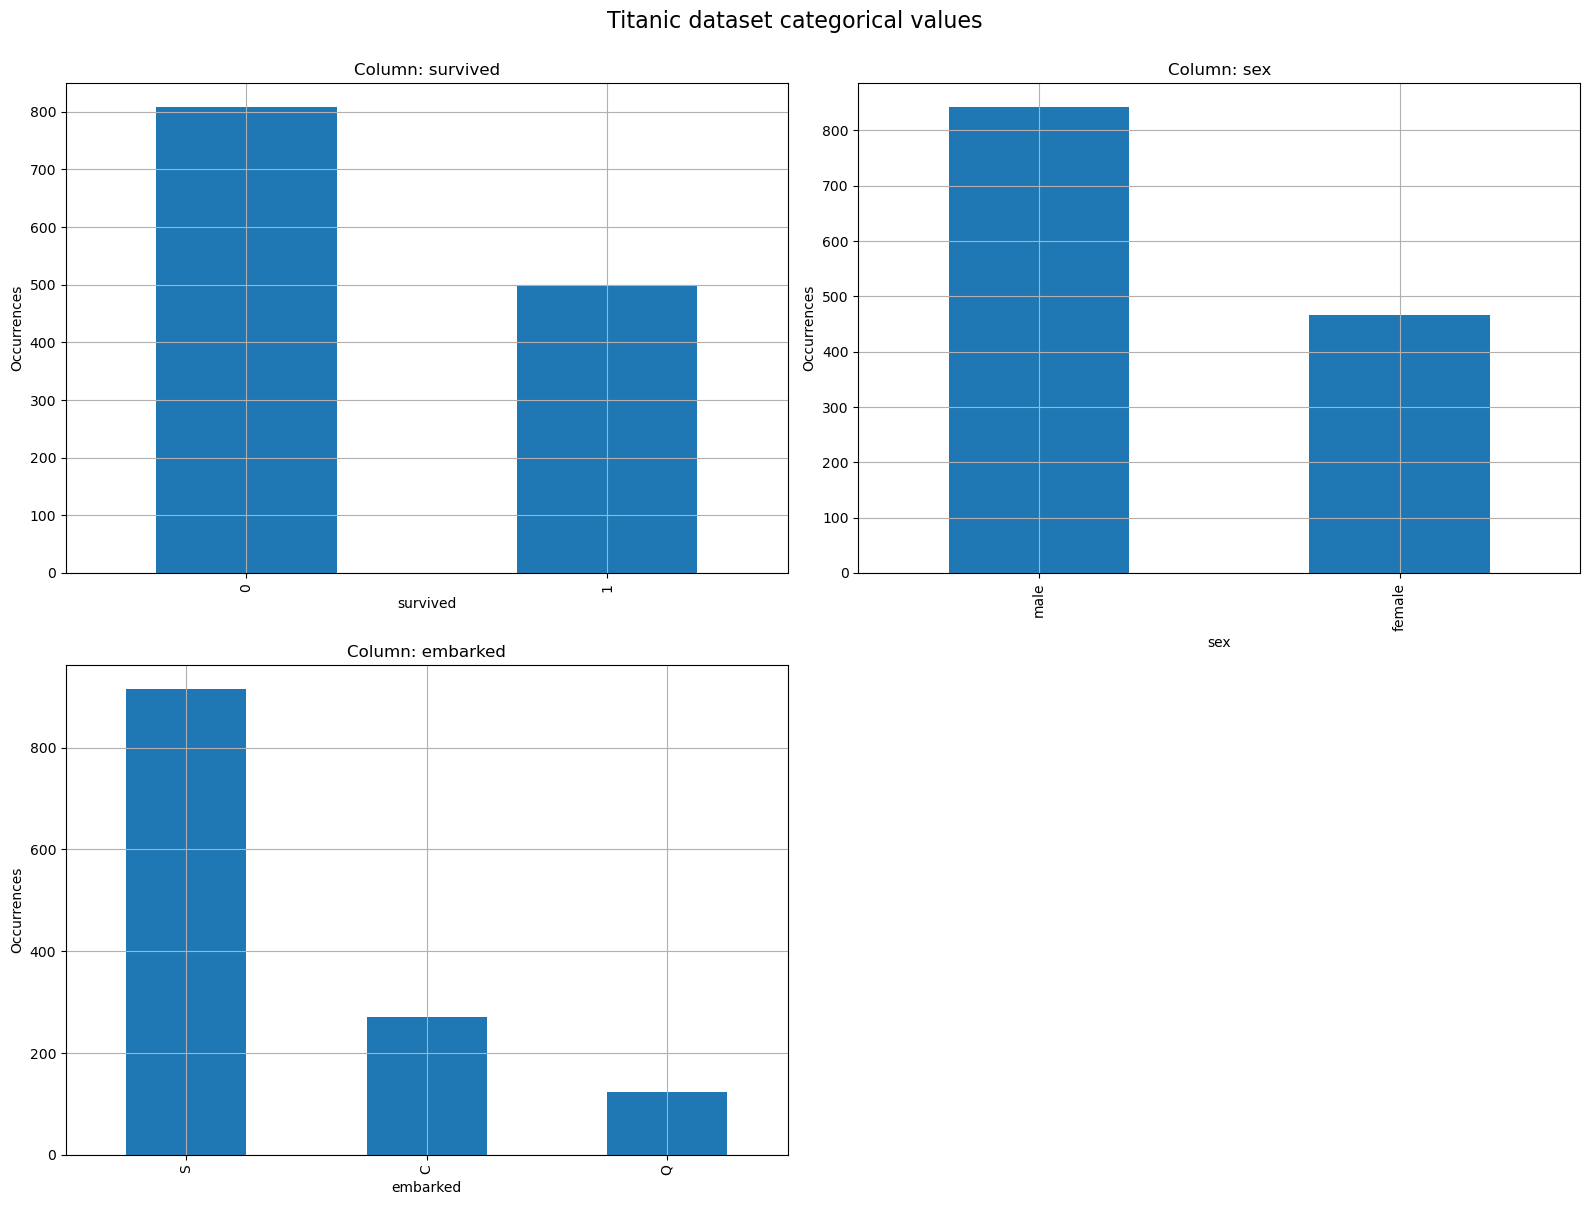

In [25]:
plot_df_categorical_features(titanic_df, 'Titanic dataset categorical values')

### Preparation of Models' Input Data and Targets

In [26]:
titanic_X = titanic_df.drop('survived', axis=1)
titanic_y = titanic_df['survived'].copy()
titanic_y = titanic_y.values.astype(float)

titanic_X.to_pickle(config.files.titanic_data)
pd.DataFrame(titanic_y).to_pickle(config.files.titanic_targets)

## Wine Quality (Red)

### Data Acquisition

In [27]:
wine_quality = fetch_ucirepo(id=186) 
wine_df = wine_quality.data.original
wine_df = wine_df[wine_df['color'] == 'red']
print(wine_df.shape)
wine_df.head()

(1599, 13)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [28]:
wine_df = wine_df.drop('color', axis=1)
wine_df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Handling Invalid and Empty Values

In [29]:
wine_df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [30]:
wine_df.duplicated().sum()

240

In [31]:
wine_df.drop_duplicates(inplace=True)

### Categorical and Continuous Data Exploration

In [32]:
wine_df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


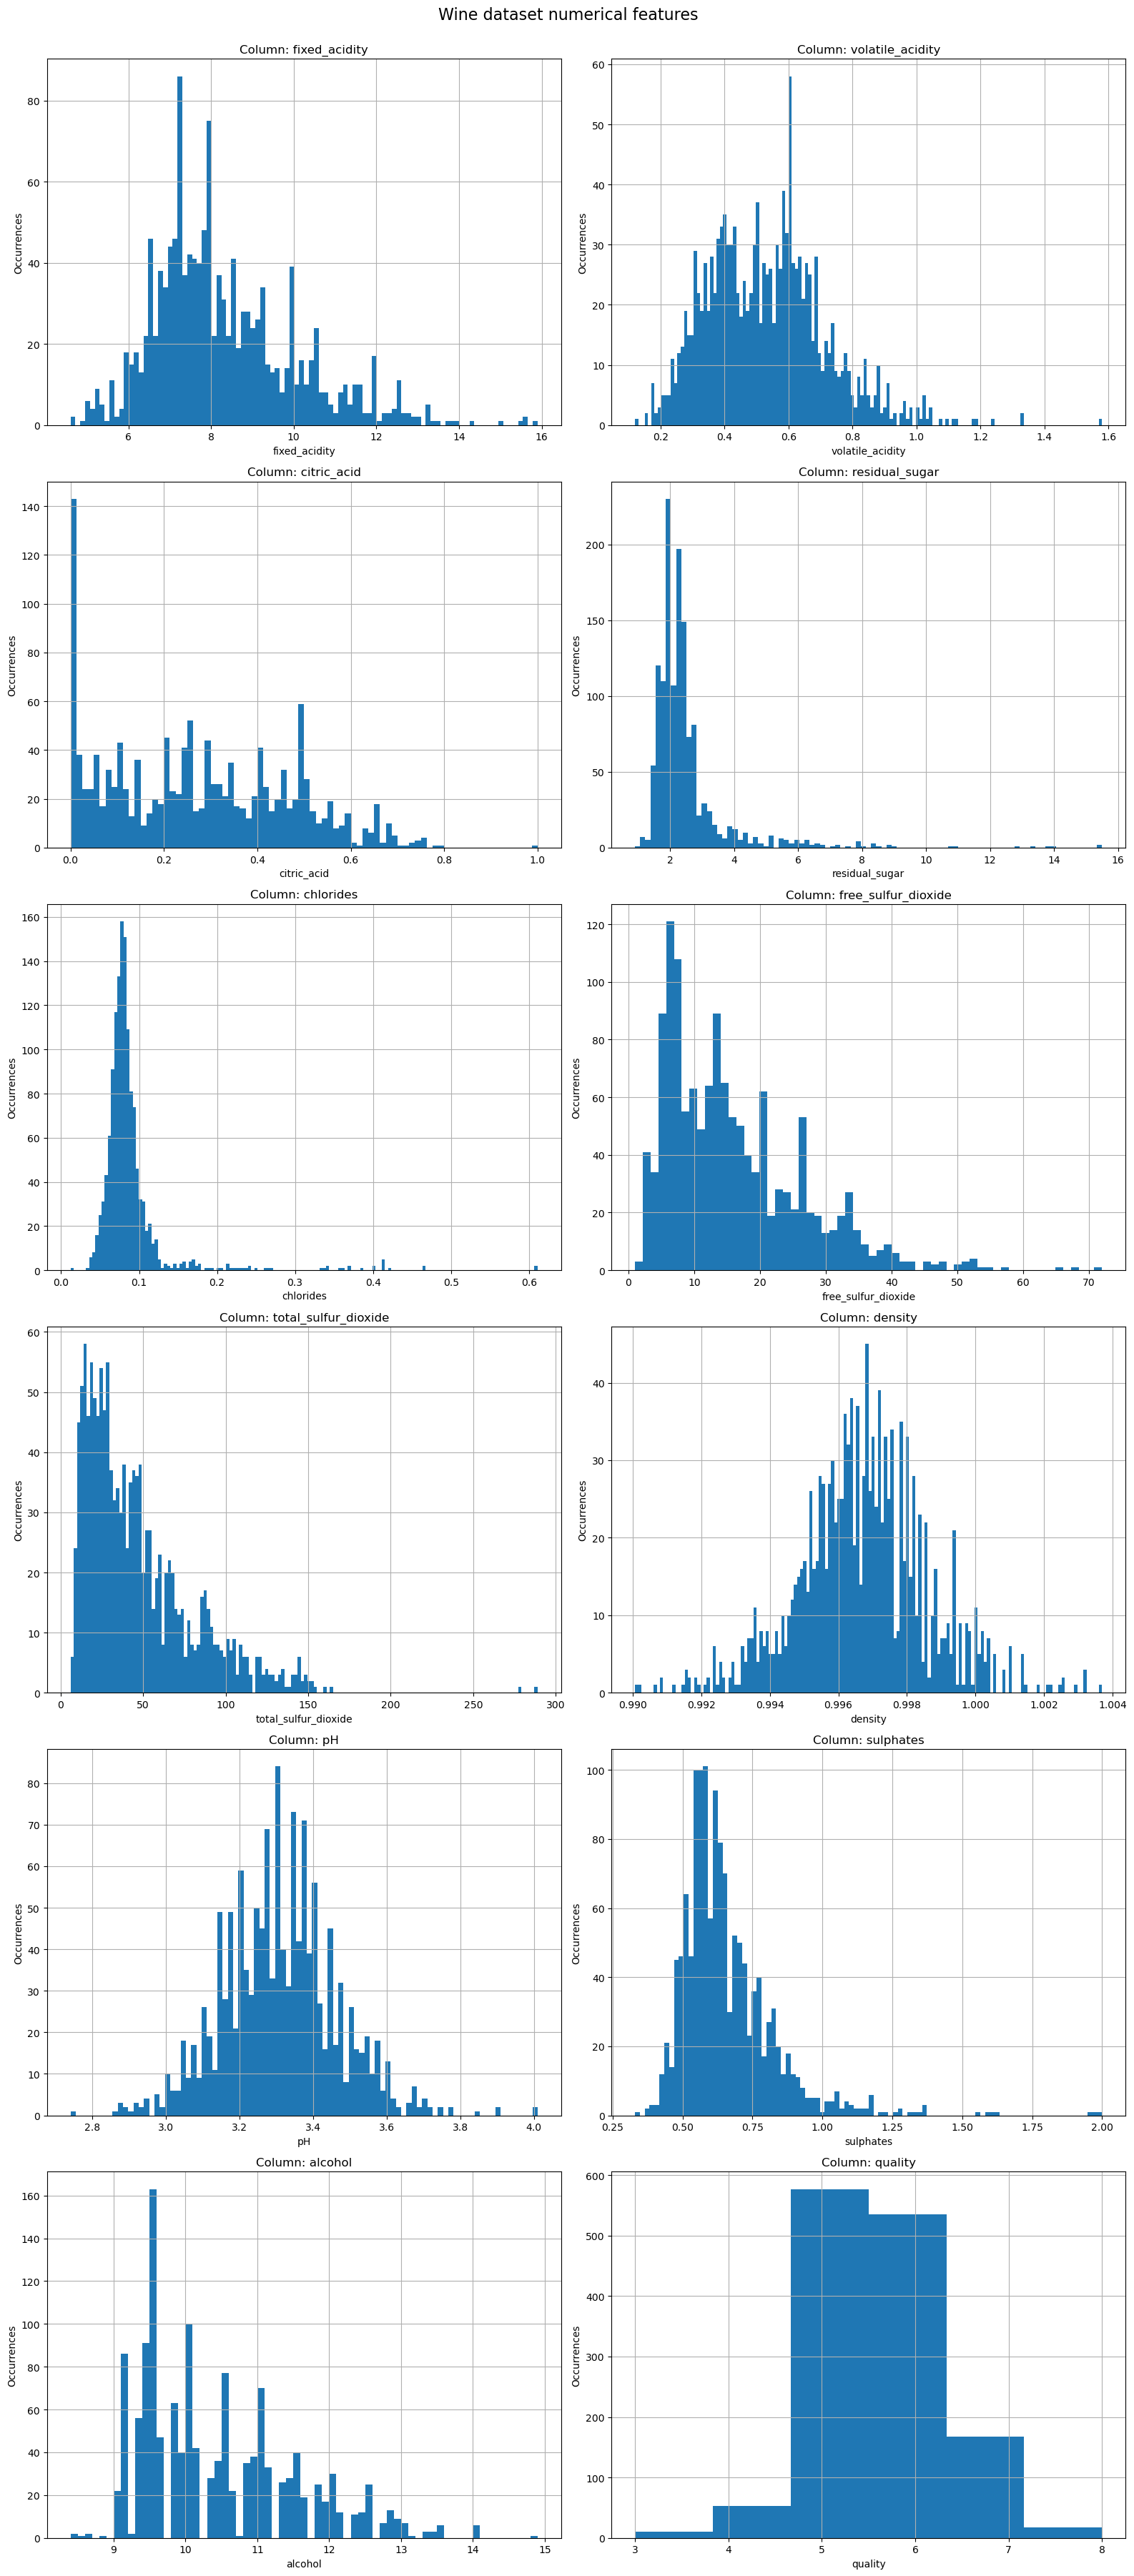

In [33]:
plot_df_numerical_features(wine_df, 'Wine dataset numerical features')

### Preparation of Models' Input Data and Targets

I treat the data in the same way as in the study, so the quality column will be used as a continuous variable.

In [34]:
wine_X = wine_df.drop('quality', axis=1)
wine_y = np.array(wine_df['quality'].copy()).reshape(-1, 1)

wine_X.to_pickle(config.files.wine_data)
pd.DataFrame(wine_y).to_pickle(config.files.wine_targets)

## Auto MPG

### Data Acquisition 

In [35]:
auto_mpg = fetch_ucirepo(id=9)
auto_df = auto_mpg.data['original']
auto_df.head()

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


In [36]:
auto_df = auto_df.drop('car_name', axis=1)
auto_df.shape

(398, 8)

### Handling Invalid and Empty Values

In [37]:
auto_df.isnull().sum()

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

In [38]:
auto_df[auto_df['horsepower'].isnull()]

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
32,4,98.0,NaN,2046,19.0,71,1,25.0
126,6,200.0,NaN,2875,17.0,74,1,21.0
330,4,85.0,NaN,1835,17.3,80,2,40.9
336,4,140.0,NaN,2905,14.3,80,1,23.6
354,4,100.0,NaN,2320,15.8,81,2,34.5
374,4,151.0,NaN,3035,20.5,82,1,23.0


In [39]:
auto_df.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864,23.514573
std,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [40]:
auto_df.fillna({'horsepower': auto_df.horsepower.mean()}, inplace=True)
auto_df.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64

### Categorical and Continuous Data Exploration

In [41]:
auto_df.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864,23.514573
std,1.701004,104.269838,38.199187,846.841774,2.757689,3.697627,0.802055,7.815984
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,4.000000,104.250000,76.000000,2223.750000,13.825000,73.000000,1.000000,17.500000
50%,4.000000,148.500000,95.000000,2803.500000,15.500000,76.000000,1.000000,23.000000
75%,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000,29.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


In [42]:
auto_df.nunique()

cylinders         5
displacement     82
horsepower       94
weight          351
acceleration     95
model_year       13
origin            3
mpg             129
dtype: int64

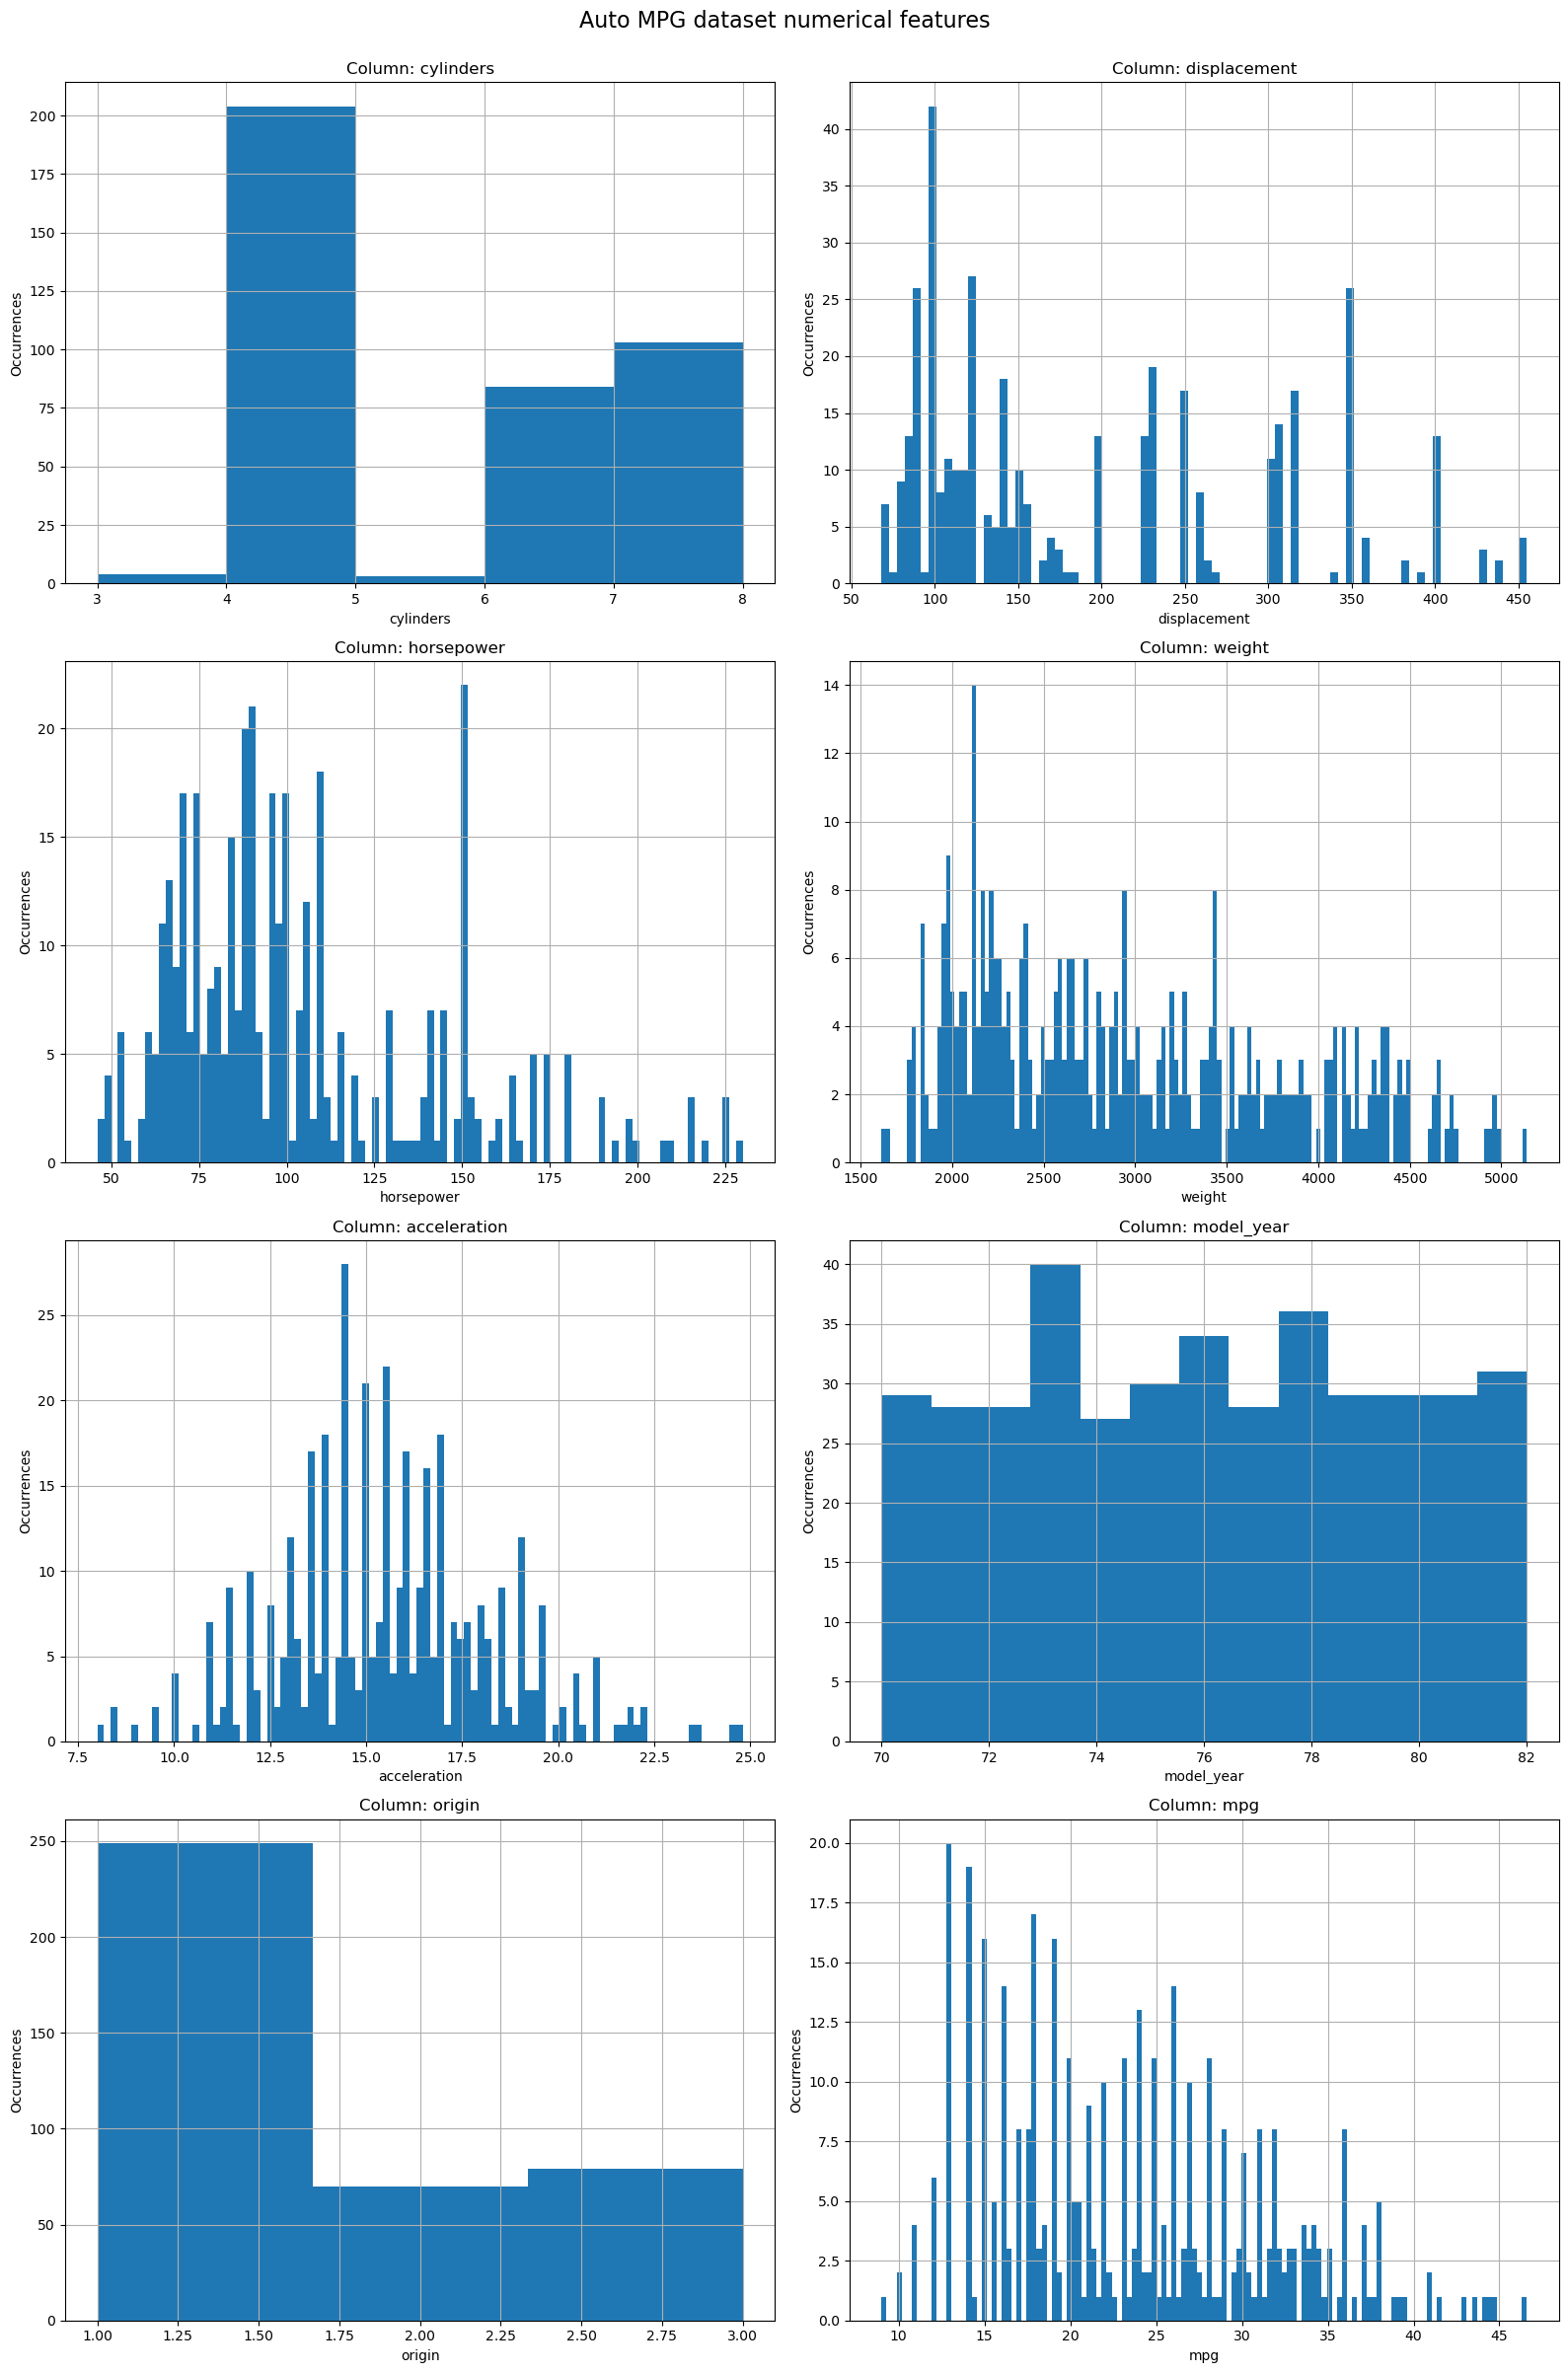

In [43]:
plot_df_numerical_features(auto_df, "Auto MPG dataset numerical features")

### Preparation of Models' Input Data and Targets

In [44]:
auto_X = auto_df.drop('mpg', axis=1)
auto_y = np.array(auto_df['mpg'].copy()).reshape(-1, 1)

auto_X.to_pickle(config.files.auto_data)
pd.DataFrame(auto_y).to_pickle(config.files.auto_targets)

## Housing

### Data Acquisition 

In [45]:
url = "https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz"
housing_col = ['longitude', 'latitude', 'housingMedianAge', 'totalRooms', 'totalBedrooms', 'population', 'households', 'medianIncome', 'medianHouseValue']
with urllib.request.urlopen(url) as f:
    tar = tarfile.open(fileobj=f, mode="r|gz")
    data_raw = [tar.extractfile(t).read() for t in tar]
housing_data = pd.read_csv(io.BytesIO(data_raw[0]), encoding='utf8', names=housing_col)
print(housing_data.shape)
housing_data.head()


(20640, 9)


,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


### Handling Invalid and Empty Values

In [46]:
housing_df = housing_data.copy()
print(housing_df.isnull().sum())

longitude           0
latitude            0
housingMedianAge    0
totalRooms          0
totalBedrooms       0
population          0
households          0
medianIncome        0
medianHouseValue    0
dtype: int64


In [47]:
housing_df.drop_duplicates(inplace=True)
print(housing_df.shape)

(20640, 9)


### Categorical and Continuous Data Exploration

In [48]:
housing_df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


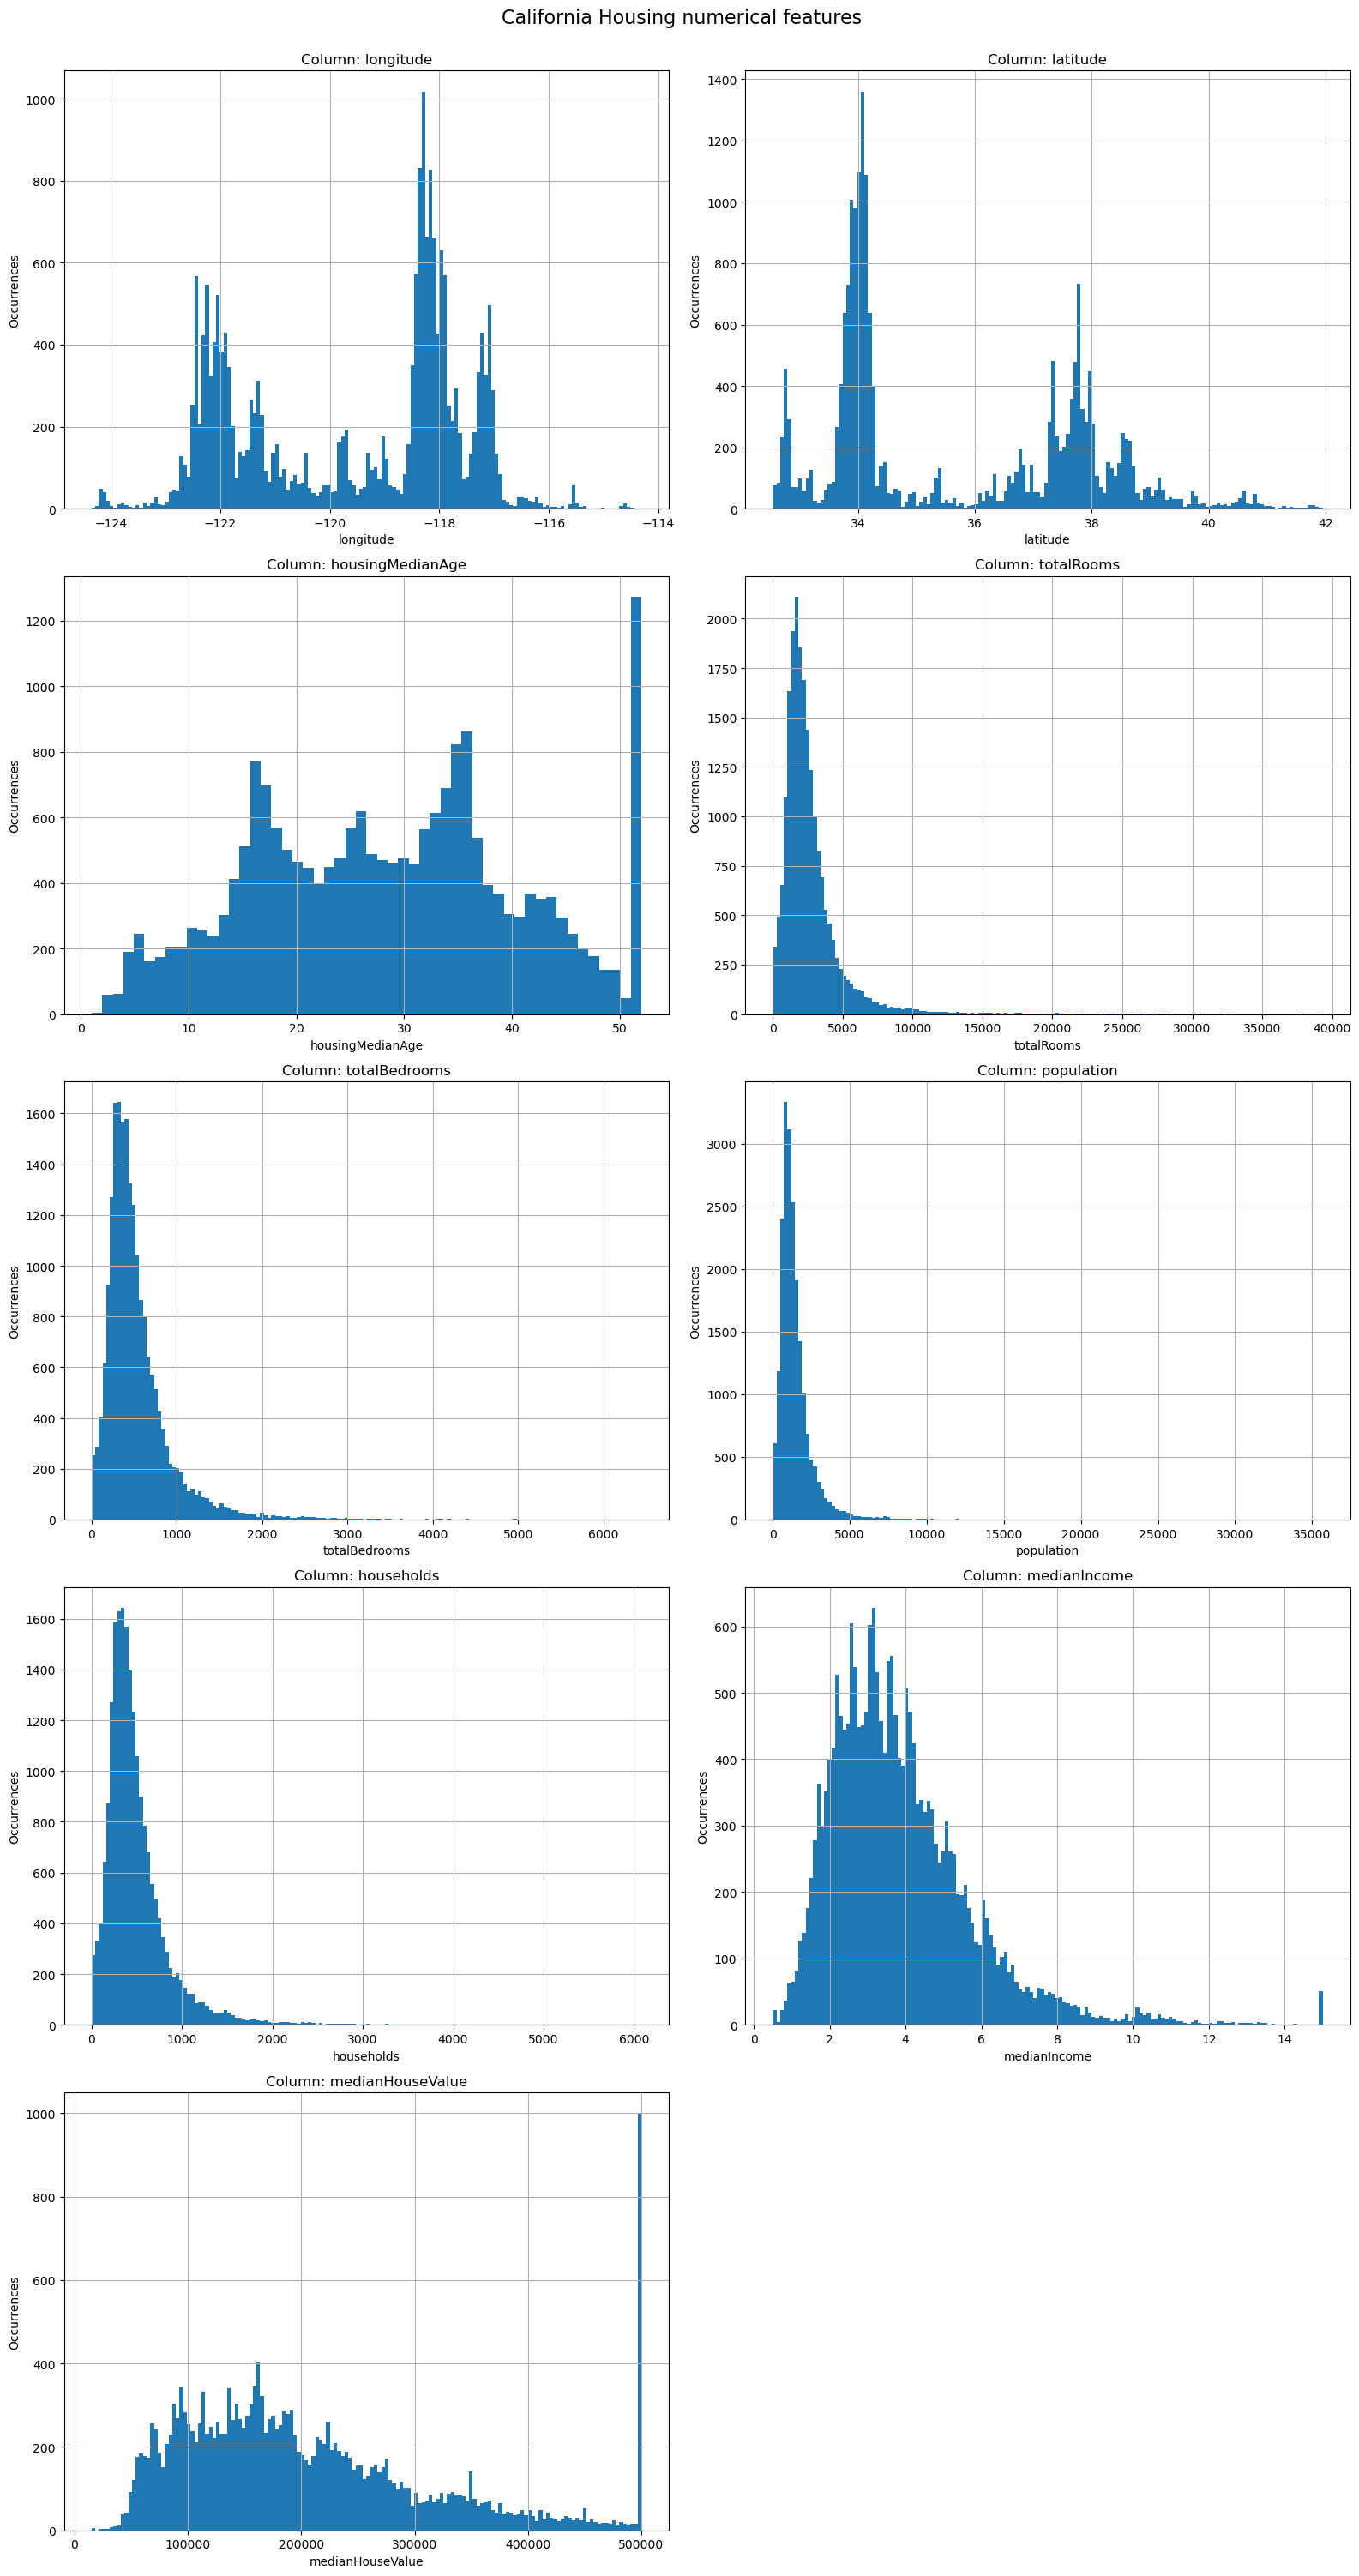

In [49]:
plot_df_numerical_features(housing_df, 'California Housing numerical features')

### Preparation of Models' Input Data and Targets

In [50]:
housing_X = housing_df.drop(['medianHouseValue'], axis=1)
housing_y = np.array(housing_df['medianHouseValue'].copy()).reshape(-1, 1)

housing_X.to_pickle(config.files.housing_data)
pd.DataFrame(housing_y).to_pickle(config.files.housing_targets)